# A glimpse into the inner working of a 2 layer Neural network

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from numpy import random as nprand
from cs771 import plotData as pd, utils, genSyntheticData as gsd
from keras.models import Sequential
from keras.layers import Dense as dense
from keras import optimizers

Using TensorFlow backend.
C:\Users\purushot\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\purushot\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\purushot\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\purushot

In [3]:
d = 2 
n = 20
r = 2

tmp1 = gsd.genSphericalData( d, n, [-5, -5], r )
tmp2 = gsd.genSphericalData( d, n, [5, 5], r )
XPos = np.vstack( (tmp1, tmp2) )
yPos = np.ones( (XPos.shape[0],) )

tmp1 = gsd.genSphericalData( d, n, [-5, 5], r )
tmp2 = gsd.genSphericalData( d, n, [5, -5], r )
XNeg = np.vstack( (tmp1, tmp2) )
yNeg = np.zeros( (XNeg.shape[0],) )

X = np.vstack( (XPos, XNeg) )
y = np.concatenate( (yPos, yNeg) )
n = X.shape[0]
idx = nprand.permutation( n )

X = X[idx]
y = y[idx]

mu = np.mean( X, axis = 0 )
sigma = np.std( X, axis = 0 )

X -= mu
X /= sigma






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Text(0, 0.5, 'Classification Accuracy')

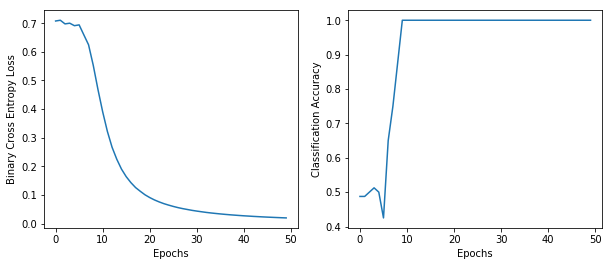

In [4]:
# You may get deprecation warnings about tensorflow when you run
# this cell for the first time. This is okay and not an error
# It seems TF has disabled several functional API in its new version
# and keras routines have not (yet) been upgraded to use them and
# continue to use the old (deprecated) routines hence the warnings

model = Sequential()
model.add( dense( units = 2, activation = "sigmoid", input_dim = 2, use_bias = True ) )
model.add( dense( units = 1, activation = "sigmoid", use_bias = True ) )
# Setting a very large learning rate lr may make the NN temperamental and cause
# it to converge to a local optima. Keras supports "callbacks" which allow the
# user to dynamically lower learning rate if progress has stalled
opt = optimizers.Adam( lr = 0.1, beta_1 = 0.9, beta_2 = 0.999, amsgrad = True )
# Metrics are just for sake of display, not for sake of training
# Set verbose = 1 or 2 to see metrics reported for every epoch of training
# Notice that whereas loss value goes down almost monotonically, the accuracy
# may fluctuate i.e. go down a bit before finally going up again
model.compile( loss = "binary_crossentropy", optimizer = opt, metrics = ["binary_accuracy"] )
history = model.fit( X, y, epochs = 50, batch_size = n//8, verbose = 0 )

fig0, ax0 = pd.getFigList( nrows = 1, ncols = 2, sizex = 5, sizey = 4 )
ax0[0].plot(history.history['loss'])
ax0[1].plot(history.history['binary_accuracy'])
ax0[0].set_xlabel( "Epochs" )
ax0[0].set_ylabel( "Binary Cross Entropy Loss" )
ax0[1].set_xlabel( "Epochs" )
ax0[1].set_ylabel( "Classification Accuracy" )

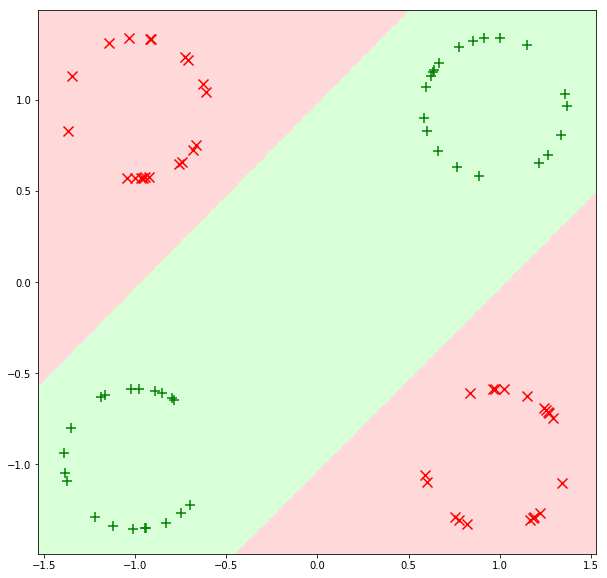

In [5]:
def ffpredict( X ):
    # Our shading code anyway converts predictions to [0,1] scores
    return model.predict_classes( X )

fig = pd.getFigure( 10, 10 )
(xlim, ylim) = np.max( np.abs( X ), axis = 0 ) * 1.1
pd.shade2D( ffpredict, fig, mode = "batch", xlim = xlim, ylim = ylim )
pd.plot2D( X[y == 1], fig, color = 'g', marker = '+' )
pd.plot2D( X[y == 0], fig, color = 'r', marker = 'x' )

[array([[ 8.140034 ,  6.2257695],
       [-8.022345 , -6.2070103]], dtype=float32), array([ 7.6521316, -6.4985967], dtype=float32)]
[array([[ 7.7717934],
       [-8.765444 ]], dtype=float32), array([-3.4945343], dtype=float32)]


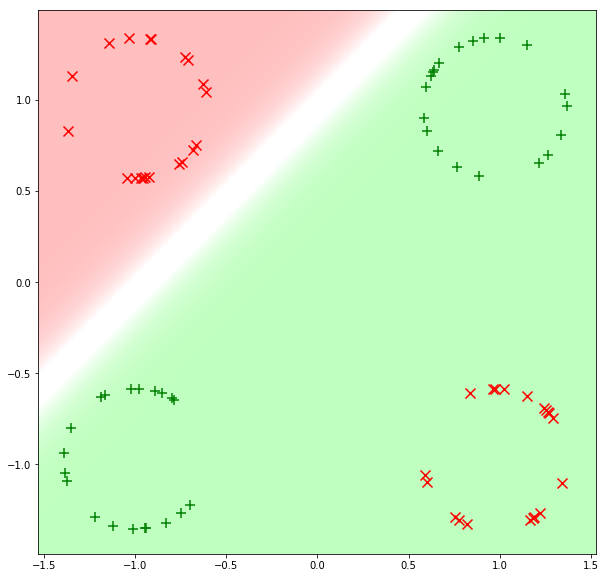

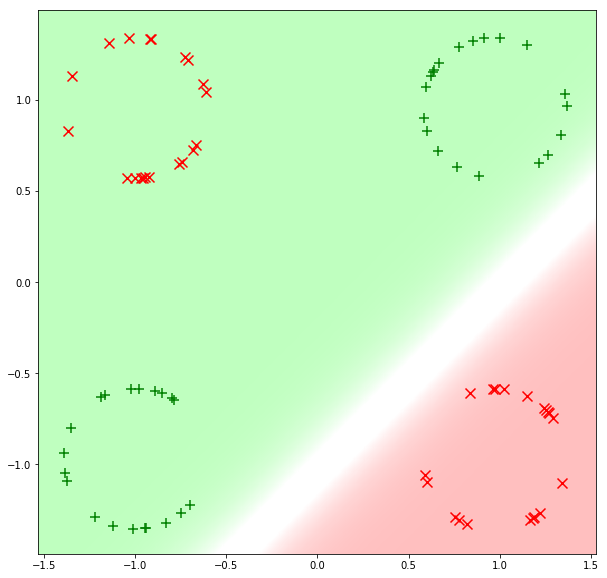

In [6]:
def sigmoid( a ):
    return 1/(1 + np.exp( -a ))

def getHiddenLayerActivations( X ):
    return sigmoid( X.dot( w ) + b )

# Our network learns a function of the form (s = sigmoid function)
# s( u.T * s( P.T * x + q ) + v )

# Weights that go to the hidden layer
P = model.layers[0].get_weights()[0]
q = model.layers[0].get_weights()[1]

# Weights that go to the output layer
u = model.layers[1].get_weights()[0]
v = model.layers[1].get_weights()[1]

# Get the post activations of the first hidden layer neuron
# The multiplication with sign(u[0]) is just to make sure
# that the colors turn out nicely in the plots
w = P[:,0] * np.sign( u[0] ) 
b = q[0] * np.sign( u[0] )

fig2 = pd.getFigure( 10, 10 )
pd.shade2DProb( getHiddenLayerActivations, fig2, mode = "batch", xlim = xlim, ylim = ylim )
pd.plot2D( X[y == 1], fig2, color = 'g', marker = '+' )
pd.plot2D( X[y == 0], fig2, color = 'r', marker = 'x' )

# Get the post activations of the second hidden layer neuron
# The multiplication with sign(u[1]) is yet again just to make
# sure that the colors turn out nicely in the plots
w = P[:,1] * np.sign( u[1] ) 
b = q[1] * np.sign( u[1] )

fig3 = pd.getFigure( 10, 10 )
pd.shade2DProb( getHiddenLayerActivations, fig3, mode = "batch", xlim = xlim, ylim = ylim )
pd.plot2D( X[y == 1], fig3, color = 'g', marker = '+' )
pd.plot2D( X[y == 0], fig3, color = 'r', marker = 'x' )

# Note that the two nodes in the hidden layer cooperate to learn the classifier
# Neither node can fully classify the red points from the green points on its own
# so they share the burden. Each node takes up the responsibility of isolating
# one red clump from the rest of the data. Together they make a perfect classifier :)
# One can interpret these two nodes as learning two useful features such that the
# learning problem become linearly separable when given these two new features
print( model.layers[0].get_weights() )
print( model.layers[1].get_weights() )

# See the value of the weights below and verify that they indeed are of the form
# that we saw in the toy code (that demonstrated universality of NN)